# German Credit Dataset

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re
#for EDA
from ydata_profiling import ProfileReport

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#for preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder

#for model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.linear_model import LogisticRegression as lr
from sklearn.tree import DecisionTreeClassifier as dt 
from sklearn.svm import SVC as vc
from sklearn.ensemble import RandomForestClassifier as rcl
import sklearn.metrics as sm

## Loading the Dataset

### Importing data

In [2]:
German_data = pd.read_csv('data/german.data')
German_data.head()

A11 6 A34 A43 1169 A65 A75 4 A93 A101 4 A121 67 A143 A152 2 A173 1 A192 A201 1
0  A12 48 A32 A43 5951 A61 A73 2 A92 A101 2 A121 ...                            
1  A14 12 A34 A46 2096 A61 A74 2 A93 A101 3 A121 ...                            
2  A11 42 A32 A42 7882 A61 A74 2 A93 A103 4 A122 ...                            
3  A11 24 A33 A40 4870 A61 A73 3 A93 A101 4 A124 ...                            
4  A14 36 A32 A46 9055 A65 A73 2 A93 A101 4 A124 ...

As we can see, the data currently has no column name and all values are status codes. We need to restructure the dataset by adding column headers and replace status codes with descriptive labes for more effective analysis and reporting.

In [3]:
col_names = ["checking-account","duration","credit-history",\
         "purpose","credit-amount","savings-account","employment-since",\
         "installment-rate","personal-status-and-sex",\
         "other-debtors","residence-since","property","age",\
        "other-installment","housing","existing-credits",\
        "job","number-of-people-provide-maintenance-for","telephone","foreign-worker","risk"]
checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM"}
credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
savings_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= <1000 DM", "A64" :">= 1000 DM"}
employment_since={'A75':">= 7 years", 'A74':"4 <= <7 years",  'A73':"1 <= <4 years", 'A72':"<1 years",'A71':"unemployed"}
personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
other_installment={'A143':"none", 'A142':"store", 'A141':"bank"}
housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
telephone={'A192':"yes", 'A191':"none"}
foreign_worker={'A201':"yes", 'A202':"no"}
risk={1:"Good Risk", 2:"Bad Risk"}


In [4]:
German_data = pd.read_csv('data/german.data', names=col_names, sep=" ")
German_data['checking-account'] = German_data['checking-account'].map(checking_account)
German_data['credit-history'] = German_data['credit-history'].map(credit_history)
German_data['purpose'] = German_data['purpose'].map(purpose)
German_data['savings-account'] = German_data['savings-account'].map(savings_account)
German_data['employment-since'] = German_data['employment-since'].map(employment_since)
German_data['personal-status-and-sex'] = German_data['personal-status-and-sex'].map(personal_status_and_sex)
German_data['other-debtors'] = German_data['other-debtors'].map(other_debtors)
German_data['property'] = German_data['property'].map(property)
German_data['other-installment'] = German_data['other-installment'].map(other_installment)
German_data['housing'] = German_data['housing'].map(housing)
German_data['job'] = German_data['job'].map(job)
German_data['telephone'] = German_data['telephone'].map(telephone)
German_data['foreign-worker'] = German_data['foreign-worker'].map(foreign_worker)
German_data['risk'] = German_data['risk'].map(risk)
German_data.head()

checking-account  duration                            credit-history  \
0                <0 DM         6                          critical account   
1         0 <= <200 DM        48  existing credits paid back duly till now   
2  no checking account        12                          critical account   
3                <0 DM        42  existing credits paid back duly till now   
4                <0 DM        24                       delay in paying off   

               purpose  credit-amount     savings-account employment-since  \
0     radio/television           1169  no savings account       >= 7 years   
1     radio/television           5951             <100 DM    1 <= <4 years   
2            education           2096             <100 DM    4 <= <7 years   
3  furniture/equipment           7882             <100 DM    4 <= <7 years   
4            car (new)           4870             <100 DM    1 <= <4 years   

   installment-rate            personal-status-and-sex other-debtors  ...  \
0                 4                        male:single          none  ...   
1                 2  female:divorced/separated/married          none  ...   
2                 2                        male:single          none  ...   
3                 2                        male:single     guarantor  ...   
4                 3                        male:single          none  ...   

                           property age  other-installment   housing  \
0                       real estate  67               none       own   
1                       real estate  22               none       own   
2                       real estate  49               none       own   
3  savings agreement/life insurance  45               none  for free   
4             unknown / no property  53               none  for free   

  existing-credits                          job  \
0                2  skilled employee / official   
1                1  skilled employee / official   
2                1         unskilled - resident   
3                1  skilled employee / official   
4                2  skilled employee / official   

  number-of-people-provide-maintenance-for  telephone foreign-worker  \
0                                        1        yes            yes   
1                                        1       none            yes   
2                                        2       none            yes   
3                                        2       none            yes   
4                                        2       none            yes   

        risk  
0  Good Risk  
1   Bad Risk  
2  Good Risk  
3  Good Risk  
4   Bad Risk  

[5 rows x 21 columns]

In [5]:
German_data.describe().T

count      mean          std  \
duration                                  1000.0    20.903    12.058814   
credit-amount                             1000.0  3271.258  2822.736876   
installment-rate                          1000.0     2.973     1.118715   
residence-since                           1000.0     2.845     1.103718   
age                                       1000.0    35.546    11.375469   
existing-credits                          1000.0     1.407     0.577654   
number-of-people-provide-maintenance-for  1000.0     1.155     0.362086   

                                            min     25%     50%      75%  \
duration                                    4.0    12.0    18.0    24.00   
credit-amount                             250.0  1365.5  2319.5  3972.25   
installment-rate                            1.0     2.0     3.0     4.00   
residence-since                             1.0     2.0     3.0     4.00   
age                                        19.0    27.0    33.0    42.00   
existing-credits                            1.0     1.0     1.0     2.00   
number-of-people-provide-maintenance-for    1.0     1.0     1.0     1.00   

                                              max  
duration                                     72.0  
credit-amount                             18424.0  
installment-rate                              4.0  
residence-since                               4.0  
age                                          75.0  
existing-credits                              4.0  
number-of-people-provide-maintenance-for      2.0

In [6]:
German_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   checking-account                          1000 non-null   object
 1   duration                                  1000 non-null   int64 
 2   credit-history                            1000 non-null   object
 3   purpose                                   1000 non-null   object
 4   credit-amount                             1000 non-null   int64 
 5   savings-account                           1000 non-null   object
 6   employment-since                          1000 non-null   object
 7   installment-rate                          1000 non-null   int64 
 8   personal-status-and-sex                   1000 non-null   object
 9   other-debtors                             1000 non-null   object
 10  residence-since                           1000 no

It seems like this datasat does not have any missing values.

## Data Exploration and Visualization

In [7]:
profile = ProfileReport(German_data, title = "Pandas Profiling Report for German Credit dataset")
profile.to_file(output_file="German_Credit_profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
profile

### Categorical Column Analysis

#### Ordinal Categorical Columns

In this dataset, there are certain columns that I believe are ordinal categorical columns. They are 'checking-account', 'employment-since', and 'savings-account'. For these types of categorical columns, we should use Ordinal Encoding to achive the best model performance.

#### Nominal Categorical Columns

For the rest, I prefer using One Hot Encoding since it disregards any ranking or priority among the values, treating them equally.

### Numerical Column Analysis

#### Credit-amount

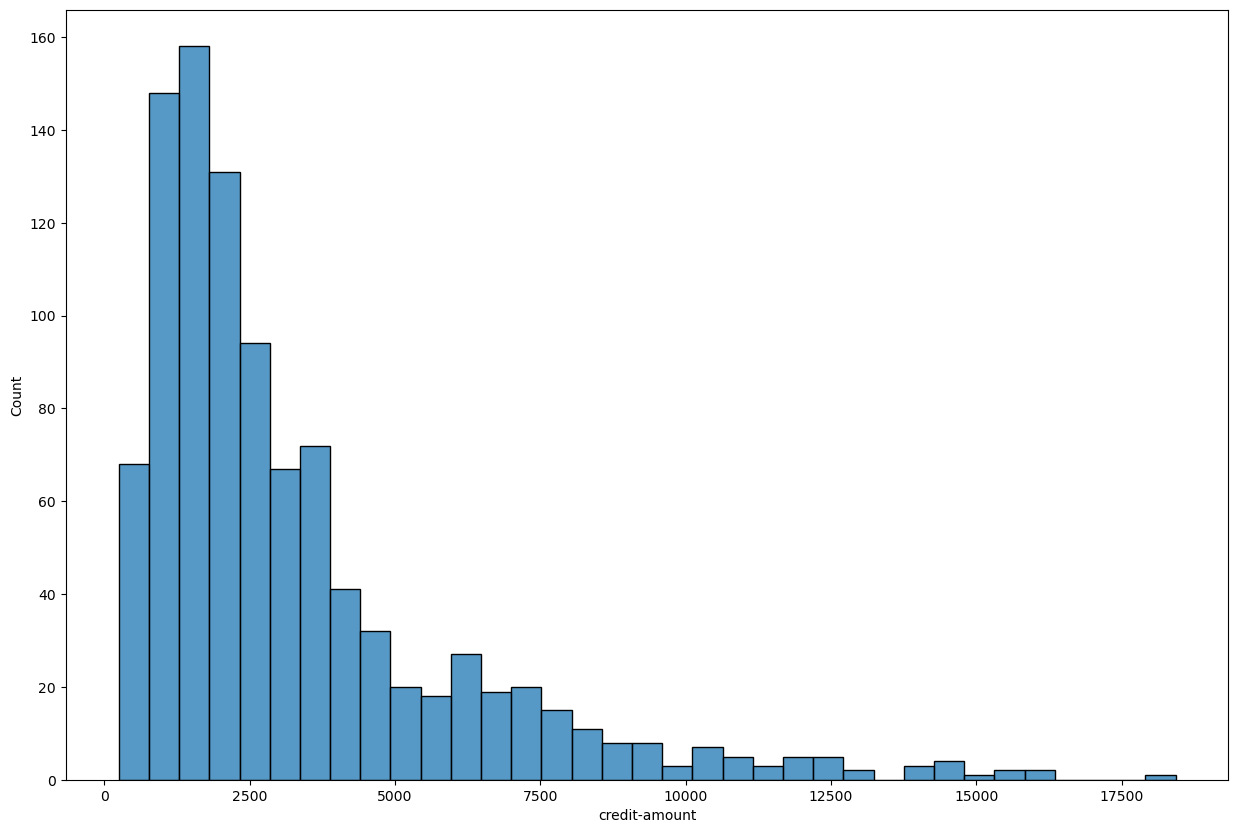

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['credit-amount'])
plt.show()

It is clear that the 'credit-amount' following the Gaussian distribution. 

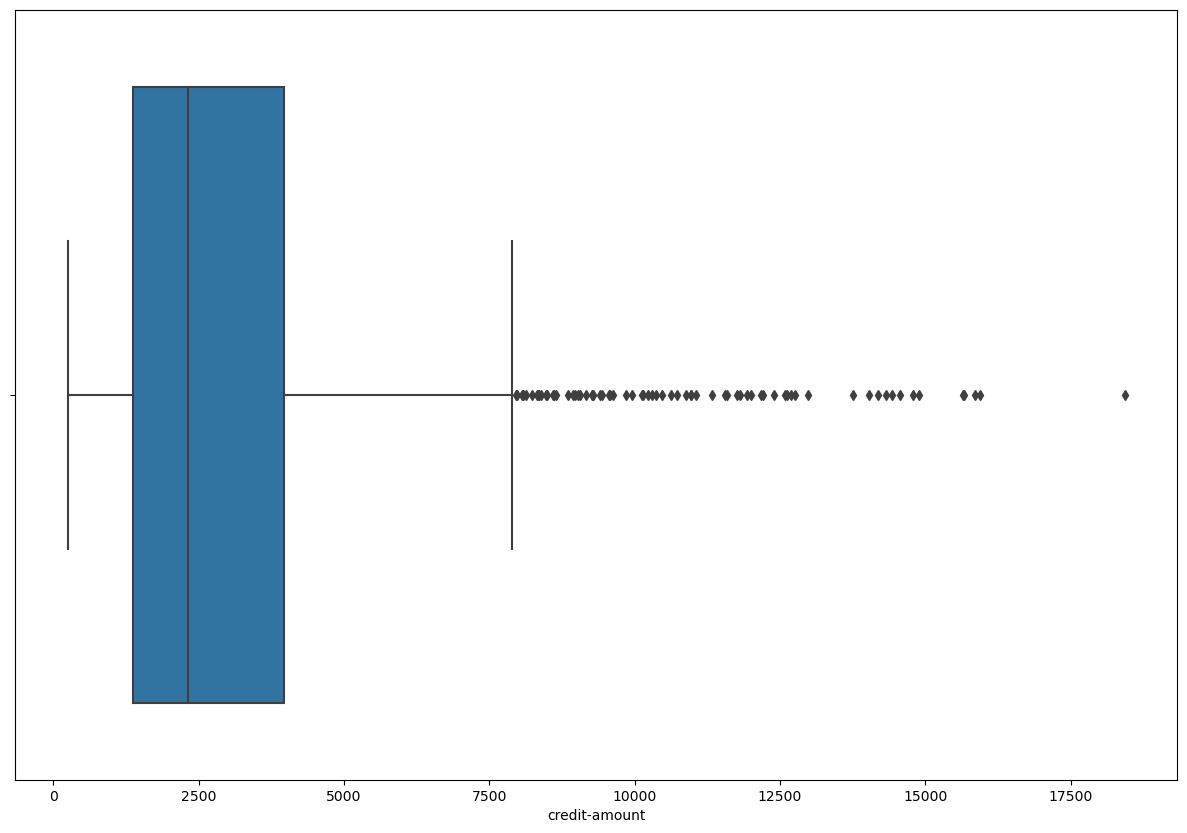

In [10]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['credit-amount'])
plt.show()

However, this column is facing with the problem that there are many outliers from 8000 to over 17500. So, instead of using standard scaling, we should use outliers treatment such as IQR to deal with those outliers. Morever, we can try to apply log transformation since it is positively skewed.

#### Age

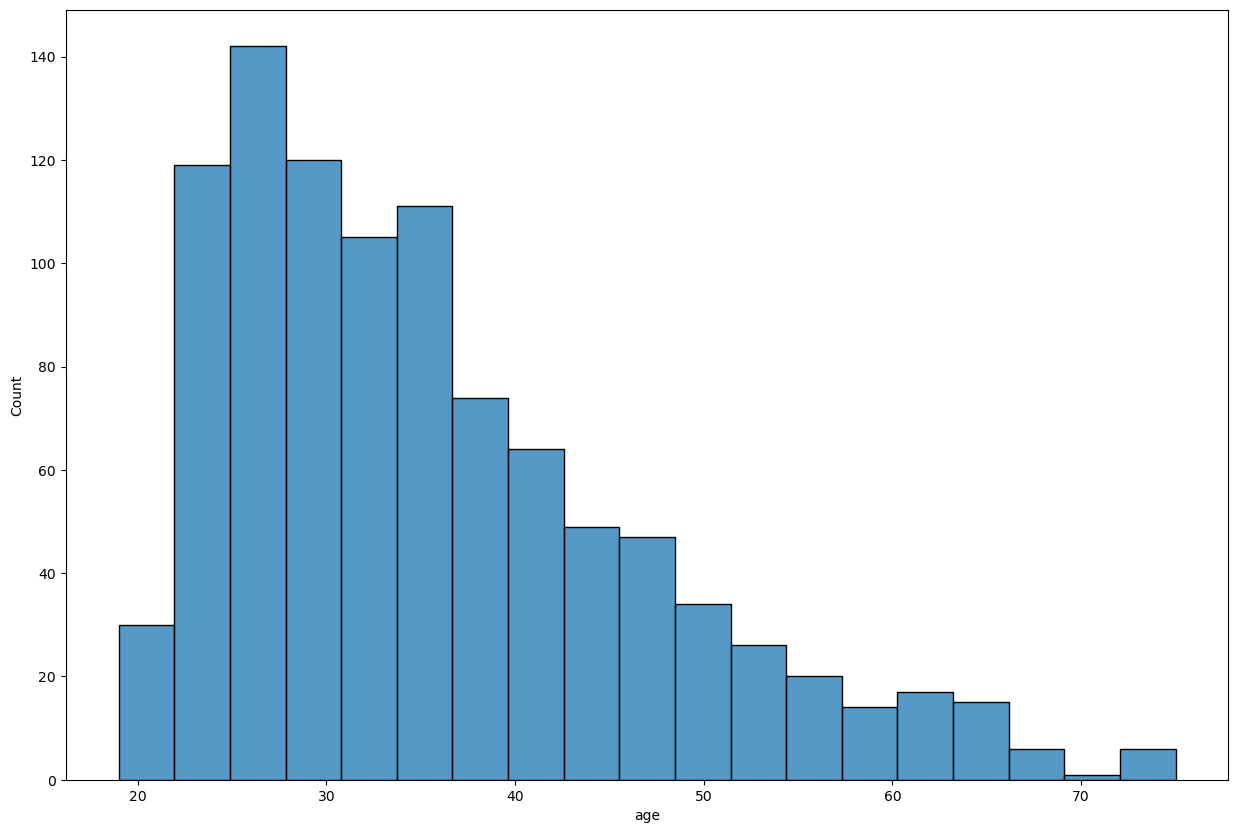

In [11]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['age'])
plt.show()

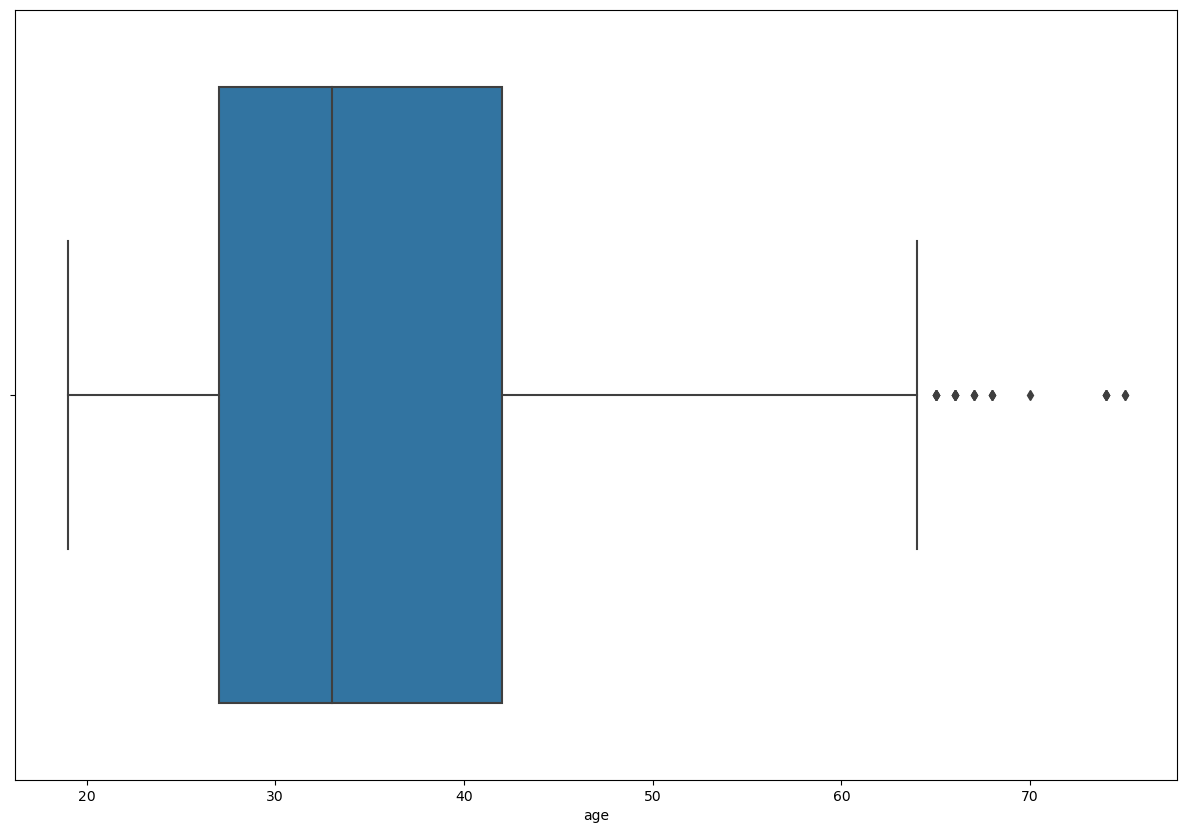

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['age'])
plt.show()

Based on the chart, the majority of participants'ages in the survey fall within the range of 27 to 42, with relatively few outliers and I belive it is following the Gaussian distribution. Therefore, we can use standard scaling for it and IQR method to deal with outliers.

#### duration

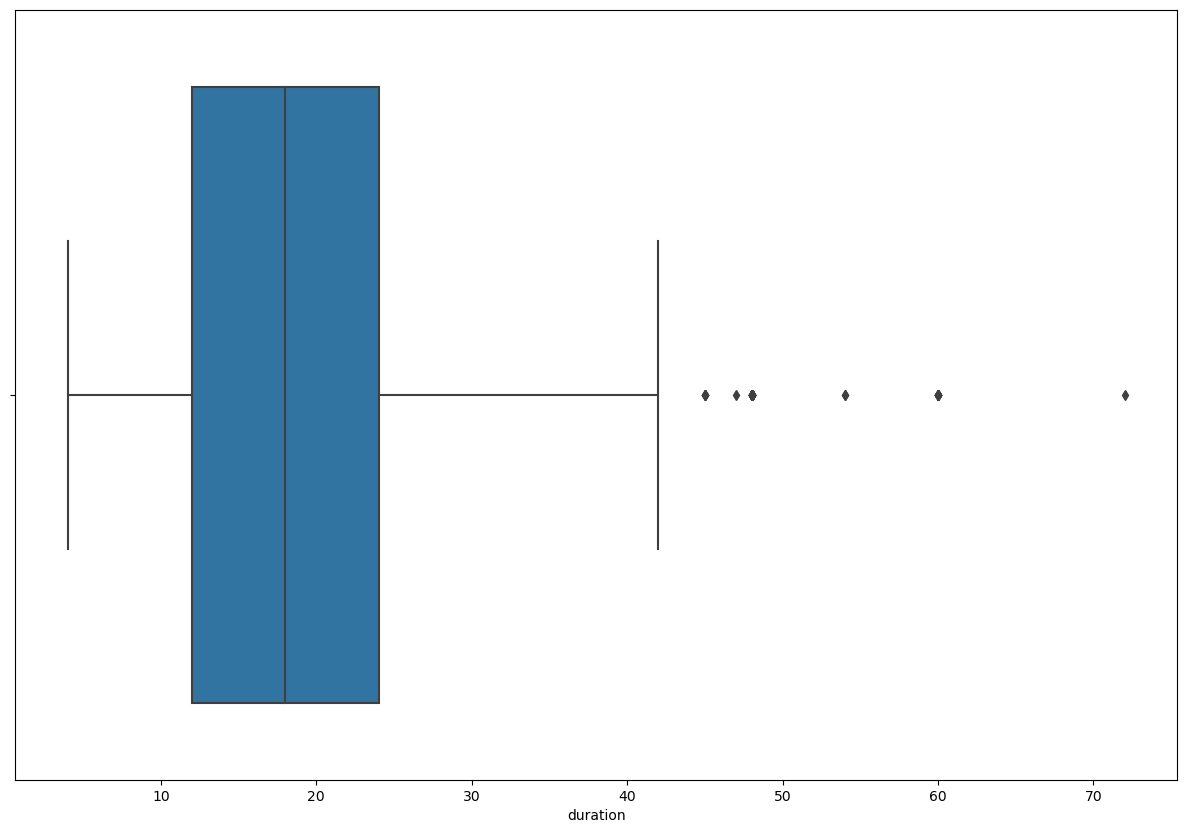

In [13]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['duration'])
plt.show()

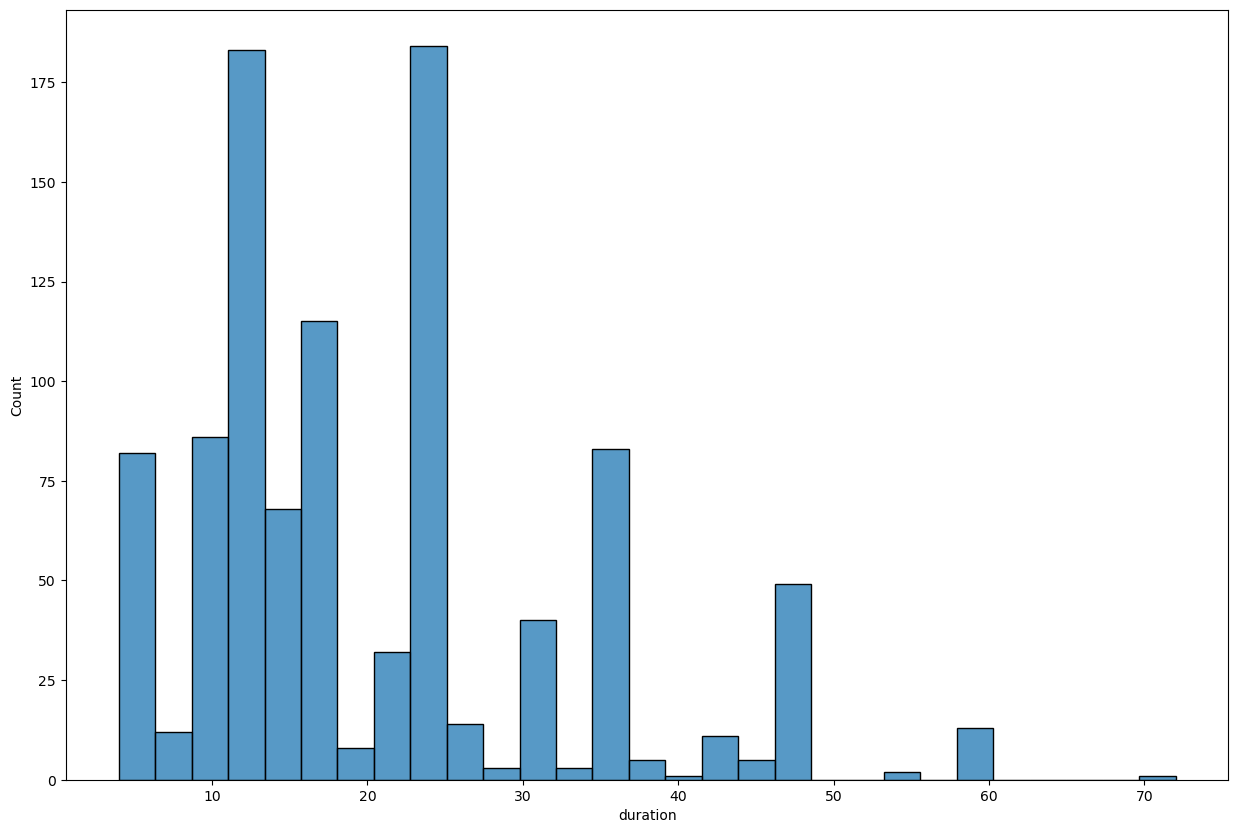

In [14]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['duration'])
plt.show()

The distribution of 'duration' column is uncertain, with data concentrated between 12 and 24. Therefore, we can use standard scaling after applying outlier treatment.

#### Remaining Numerical Columns

The remaining numerical columns only contain values ranging from 1 to 4 or 1 to 2, we can typically leave them as is. Since the values are within a very limited range, traditional scaling methods like Min-Max scaling or Z-score standardization may not provide significant benefits. But we can try to use binning approach because we can observe a significant difference between one value and the remaining three values. In this case, I will apply it on these columns: 'installment-rate', and 'residence-since'.

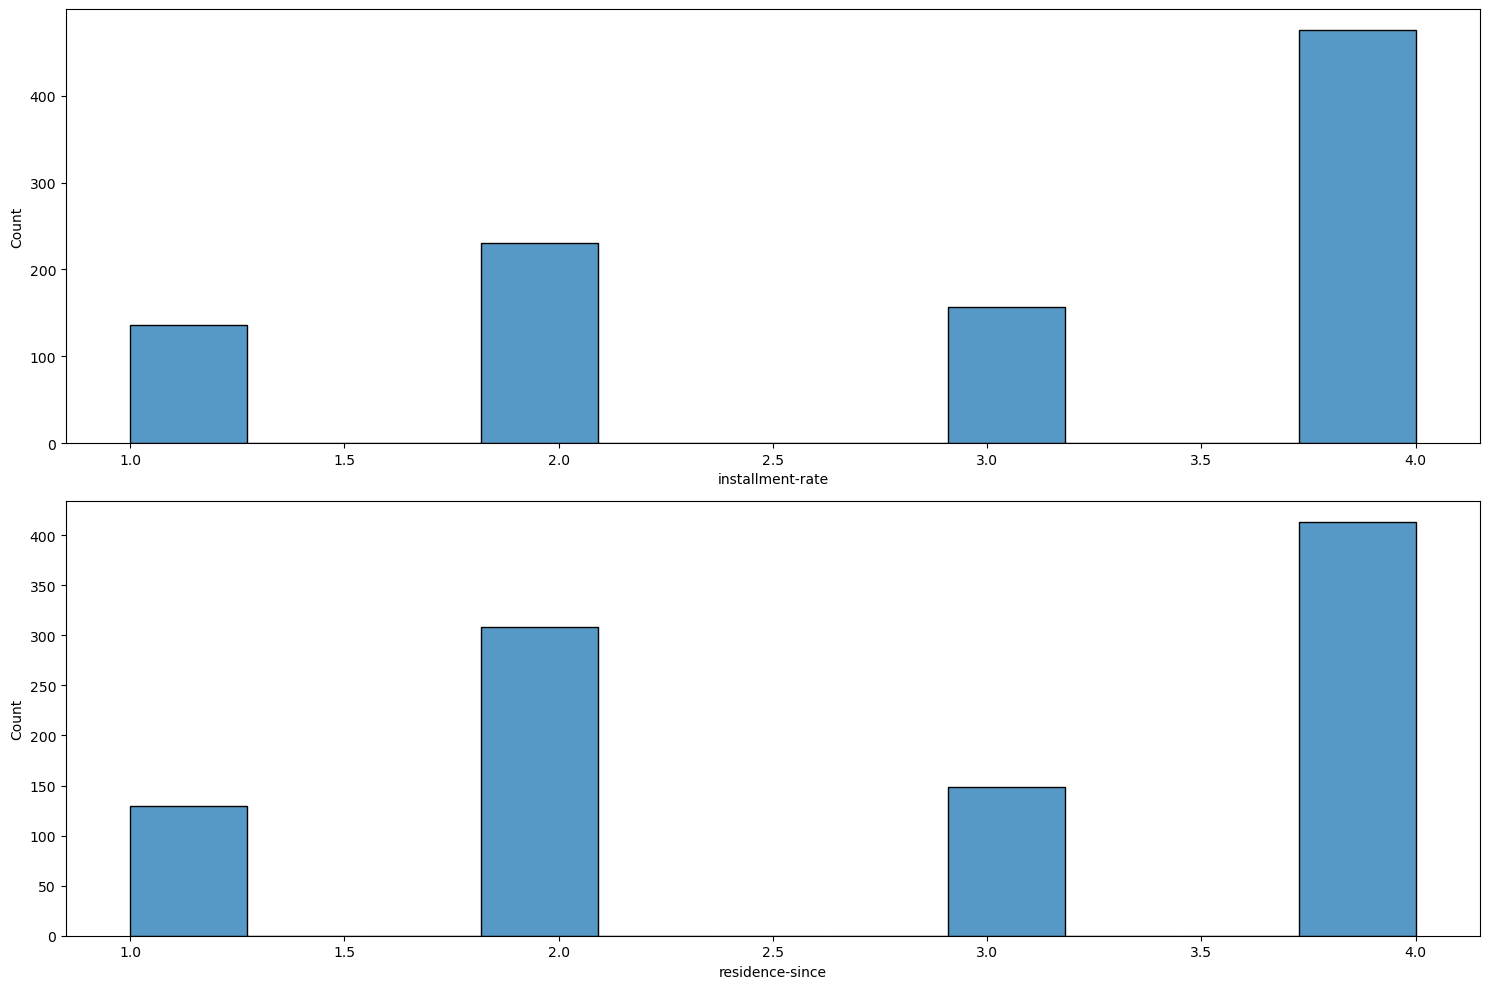

In [15]:
fig, ax = plt.subplots(2, figsize=(15, 10))
sns.histplot(x = German_data['installment-rate'], ax = ax[0])
sns.histplot(x = German_data['residence-since'], ax = ax[1])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [16]:
categorical_columns = list(German_data.select_dtypes(include=['object']).columns)
print(categorical_columns)
numerical_columns = list(German_data.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_columns)

['checking-account', 'credit-history', 'purpose', 'savings-account', 'employment-since', 'personal-status-and-sex', 'other-debtors', 'property', 'other-installment', 'housing', 'job', 'telephone', 'foreign-worker', 'risk']
['duration', 'credit-amount', 'installment-rate', 'residence-since', 'age', 'existing-credits', 'number-of-people-provide-maintenance-for']


### Outliers Treatment

In [17]:
def outlier_thresholds(column):
    sorted(column)
    Q1 = np.quantile(column, 0.25)
    Q3 = np.quantile(column, 0.75)
    IQR = Q3-Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)
    return lower_bound, upper_bound


In [18]:
outliers_column = ['age', 'credit-amount', 'duration']
for i in outliers_column:
    lowerbound, upperbound = outlier_thresholds(German_data[i])
    German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
    German_data[i].loc[(German_data[i] > upperbound)] = upperbound

C:\Users\Storm\AppData\Local\Temp\ipykernel_7556\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
C:\Users\Storm\AppData\Local\Temp\ipykernel_7556\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
C:\Users\Storm\AppData\Local\Temp\ipykernel_7556\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

### Encoding the Data

#### Ordinal Encoding

In [19]:
ordinal_checking = OrdinalEncoder(categories=[['<0 DM', '0 <= <200 DM', '>= 200 DM', 'no checking account']], dtype=np.int64)
German_data['checking-account'] = ordinal_checking.fit_transform(German_data[['checking-account']])
ordinal_employment = OrdinalEncoder(categories=[['unemployed', '<1 years', '1 <= <4 years', '4 <= <7 years', '>= 7 years']], dtype=np.int64)
German_data['employment-since'] = ordinal_employment.fit_transform(German_data[['employment-since']])
ordinal_saving = OrdinalEncoder(categories=[['<100 DM', '100 <= <500 DM', '500 <= <1000 DM', '>= 1000 DM', 'no savings account']], dtype=np.int64)
German_data['savings-account'] = ordinal_saving.fit_transform(German_data[['savings-account']])
already = ['checking-account', 'employment-since', 'savings-account']

#### Encoding Risk as Binary

In [20]:
mapping = {"Good Risk": 0, "Bad Risk": 1}
German_data['risk'] = German_data['risk'].map(mapping)

#### One Hot Encoding

In [21]:
ohe = ['credit-history', 'purpose', 'personal-status-and-sex', 'other-debtors', 'property', 'other-installment', 'housing', 'job', 'telephone', 'foreign-worker']
German_data = pd.get_dummies(German_data, columns=ohe, dtype=np.int64)

In [22]:
German_data.describe().T

count       mean  \
checking-account                                    1000.0     1.5770   
duration                                            1000.0    20.3070   
credit-amount                                       1000.0  3051.1010   
savings-account                                     1000.0     1.1050   
employment-since                                    1000.0     2.3840   
installment-rate                                    1000.0     2.9730   
residence-since                                     1000.0     2.8450   
age                                                 1000.0    35.4535   
existing-credits                                    1000.0     1.4070   
number-of-people-provide-maintenance-for            1000.0     1.1550   
risk                                                1000.0     0.3000   
credit-history_all credits at this bank paid ba...  1000.0     0.0490   
credit-history_critical account                     1000.0     0.2930   
credit-history_delay in paying off                  1000.0     0.0880   
credit-history_existing credits paid back duly ...  1000.0     0.5300   
credit-history_no credits taken                     1000.0     0.0400   
purpose_business                                    1000.0     0.0970   
purpose_car (new)                                   1000.0     0.2340   
purpose_car (used)                                  1000.0     0.1030   
purpose_domestic appliances                         1000.0     0.0120   
purpose_education                                   1000.0     0.0500   
purpose_furniture/equipment                         1000.0     0.1810   
purpose_others                                      1000.0     0.0120   
purpose_radio/television                            1000.0     0.2800   
purpose_repairs                                     1000.0     0.0220   
purpose_retraining                                  1000.0     0.0090   
personal-status-and-sex_female:divorced/separat...  1000.0     0.3100   
personal-status-and-sex_male:divorced/separated     1000.0     0.0500   
personal-status-and-sex_male:married/widowed        1000.0     0.0920   
personal-status-and-sex_male:single                 1000.0     0.5480   
other-debtors_co-applicant                          1000.0     0.0410   
other-debtors_guarantor                             1000.0     0.0520   
other-debtors_none                                  1000.0     0.9070   
property_car or other                               1000.0     0.3320   
property_real estate                                1000.0     0.2820   
property_savings agreement/life insurance           1000.0     0.2320   
property_unknown / no property                      1000.0     0.1540   
other-installment_bank                              1000.0     0.1390   
other-installment_none                              1000.0     0.8140   
other-installment_store                             1000.0     0.0470   
housing_for free                                    1000.0     0.1080   
housing_own                                         1000.0     0.7130   
housing_rent                                        1000.0     0.1790   
job_management/ highly qualified employee           1000.0     0.1480   
job_skilled employee / official                     1000.0     0.6300   
job_unemployed/ unskilled  - non-resident           1000.0     0.0220   
job_unskilled - resident                            1000.0     0.2000   
telephone_none                                      1000.0     0.5960   
telephone_yes                                       1000.0     0.4040   
foreign-worker_no                                   1000.0     0.0370   
foreign-worker_yes                                  1000.0     0.9630   

                                                            std    min  \
checking-account                                       1.257638    0.0   
duration                                              10.615151    4.0   
credit-amount                     

### Scaling The Data

#### Log Transformation

In [23]:
German_data['credit-amount'] = np.log(German_data['credit-amount'])

#### Standard Scaling

In [24]:
standard_scaler = StandardScaler()
German_data['age'] = standard_scaler.fit_transform(German_data['age'].values.reshape(-1, 1))
German_data['duration'] = standard_scaler.fit_transform(German_data['duration'].values.reshape(-1, 1))

#### Binning

In [25]:
German_data['residence-since'].loc[(German_data['residence-since'] < 4)] = "<4"
German_data['residence-since'].loc[(German_data['residence-since'] == 4)] = "4"
ordinal_residence = OrdinalEncoder(categories=[['<4', '4']], dtype=np.int64)
German_data['residence-since'] = ordinal_residence.fit_transform(German_data[['residence-since']])
German_data['installment-rate'].loc[(German_data['installment-rate'] < 4)] = "<4"
German_data['installment-rate'].loc[(German_data['installment-rate'] == 4)] = "4"
ordinal_installment = OrdinalEncoder(categories=[['<4', '4']], dtype=np.int64)
German_data['installment-rate'] = ordinal_installment.fit_transform(German_data[['installment-rate']])

C:\Users\Storm\AppData\Local\Temp\ipykernel_7556\1151603714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data['residence-since'].loc[(German_data['residence-since'] < 4)] = "<4"
C:\Users\Storm\AppData\Local\Temp\ipykernel_7556\1151603714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data['installment-rate'].loc[(German_data['installment-rate'] < 4)] = "<4"


## Model Building

In [26]:
German_data

checking-account  duration  credit-amount  savings-account  \
0                   0 -1.348465       7.063904                4   
1                   1  2.044611       8.691315                0   
2                   3 -0.782952       7.647786                0   
3                   0  2.044611       8.972337                0   
4                   0  0.348073       8.490849                0   
..                ...       ...            ...              ...   
995                 3 -0.782952       7.459339                0   
996                 0  0.913586       8.257645                0   
997                 3 -0.782952       6.689599                0   
998                 0  2.044611       7.520235                0   
999                 1  2.044611       8.428581                1   

     employment-since  installment-rate  residence-since       age  \
0                   4                 1                1  2.616620   
1                   2                 0                0 -1.211943   
2                   3                 0                0  1.220321   
3                   3                 0                1  0.859985   
4                   2                 0                1  1.580656   
..                ...               ...              ...       ...   
995                 3                 0                1 -0.401188   
996                 2                 1                1  0.409566   
997                 4                 1                1  0.229399   
998                 2                 1                1 -1.121859   
999                 0                 0                1 -0.761524   

     existing-credits  number-of-people-provide-maintenance-for  ...  \
0                   2                                         1  ...   
1                   1                                         1  ...   
2                   1                                         2  ...   
3                   1                                         2  ...   
4                   2                                         2  ...   
..                ...                                       ...  ...   
995                 1                                         1  ...   
996                 1                                         1  ...   
997                 1                                         1  ...   
998                 1                                         1  ...   
999                 1                                         1  ...   

     housing_own  housing_rent  job_management/ highly qualified employee  \
0              1             0                                          0   
1              1             0                                          0   
2              1             0                                          0   
3              0             0                                          0   
4              0             0                                          0   
..           ...           ...                                        ...   
995            1             0                                          0   
996            1             0                                          1   
997            1             0                                          0   
998            0             0                                          0   
999            1             0                                          0   

     job_skilled employee / official  \
0                                  1   
1                                  1   
2                                  0   
3                                  1   
4                                  1   
..                               ...   
995                                0   
996                                0   
997                                1   
998                                1   
999                                1   

     job_unemployed/ unskilled  - non-resident  job_unskilled - resident  \
0           

In [27]:
features = German_data[German_data.columns.difference(['risk'])]
target = German_data['risk']
features

age  checking-account  credit-amount  \
0    2.616620                 0       7.063904   
1   -1.211943                 1       8.691315   
2    1.220321                 3       7.647786   
3    0.859985                 0       8.972337   
4    1.580656                 0       8.490849   
..        ...               ...            ...   
995 -0.401188                 3       7.459339   
996  0.409566                 0       8.257645   
997  0.229399                 3       6.689599   
998 -1.121859                 0       7.520235   
999 -0.761524                 1       8.428581   

     credit-history_all credits at this bank paid back duly  \
0                                                    0        
1                                                    0        
2                                                    0        
3                                                    0        
4                                                    0        
..                                                 ...        
995                                                  0        
996                                                  0        
997                                                  0        
998                                                  0        
999                                                  0        

     credit-history_critical account  credit-history_delay in paying off  \
0                                  1                                   0   
1                                  0                                   0   
2                                  1                                   0   
3                                  0                                   0   
4                                  0                                   1   
..                               ...                                 ...   
995                                0                                   0   
996                                0                                   0   
997                                0                                   0   
998                                0                                   0   
999                                1                                   0   

     credit-history_existing credits paid back duly till now  \
0                                                    0         
1                                                    1         
2                                                    0         
3                                                    1         
4                                                    0         
..                                                 ...         
995                                                  1         
996                                                  1         
997                                                  1         
998                                                  1         
999                                                  0         

     credit-history_no credits taken  duration  employment-since  ...  \
0                                  0 -1.348465                 4  ...   
1                                  0  2.044611                 2  ...   
2                                  0 -0.782952                 3  ...   
3                                  0  2.044611                 3  ...   
4                                  0  0.348073                 2  ...   
..                               ...       ...               ...  ...   
995                                0 -0.782952                 3  ...   
996                                0  0.913586                 2  ...   
997                                0 -0.782952                 4  ...   
998                                0  2.044611                 2  ...   
999                                0  2.044611                 0  ...   

     purpose_education  purpose_furniture/equipment  purpose_others  \
0                    0

### Train-test splitting

In [28]:
feature_train, feature_test, label_train, label_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Model

#### Accuracy calculating

In [29]:
def calc_accuracy(method, label_test, pred):
  print("accuracy score for ", method, sm.accuracy_score(label_test,pred))
  print("precision_score for ", method, sm.precision_score(label_test,pred,average='micro'))
  print("f1 score for ", method, sm.f1_score(label_test,pred,average='micro'))
  print("recall score for ", method, sm.recall_score(label_test,pred,average='micro'))
  accuracy = sm.accuracy_score(label_test,pred)
  return accuracy

#### Logistic Regression

In [30]:
clf = lr(max_iter=250)
clf.fit(feature_train, label_train)

LogisticRegression(max_iter=250)

In [31]:
pred = clf.predict(feature_test)
lr_accuracy = calc_accuracy("Logistic Regression", label_test, pred)

accuracy score for  Logistic Regression 0.8
precision_score for  Logistic Regression 0.8
f1 score for  Logistic Regression 0.8000000000000002
recall score for  Logistic Regression 0.8


#### Gaussian Naive Bayes

In [32]:
clf = nb()
clf.fit(feature_train, label_train)

GaussianNB()

In [33]:
pred = clf.predict(feature_test)
nb_accuracy = calc_accuracy("Gaussian Naive Bayes", label_test, pred)

accuracy score for  Gaussian Naive Bayes 0.715
precision_score for  Gaussian Naive Bayes 0.715
f1 score for  Gaussian Naive Bayes 0.715
recall score for  Gaussian Naive Bayes 0.715


#### Linear Support Vector Machine

In [34]:
clf = vc(C=10, gamma=0.1, kernel='rbf')
clf.fit(feature_train, label_train)

SVC(C=10, gamma=0.1)

In [35]:
pred = clf.predict(feature_test)
svc_accuracy = calc_accuracy("SVC", label_test, pred)

accuracy score for  SVC 0.78
precision_score for  SVC 0.78
f1 score for  SVC 0.78
recall score for  SVC 0.78


#### K-Nearest Neighbors

In [36]:
clf = knn(n_neighbors=25)
clf.fit(feature_train, label_train)

KNeighborsClassifier(n_neighbors=25)

In [37]:
pred = clf.predict(feature_test.values)
knn_accuracy = calc_accuracy("KNN", label_test, pred)

accuracy score for  KNN 0.8
precision_score for  KNN 0.8
f1 score for  KNN 0.8000000000000002
recall score for  KNN 0.8


c:\Users\Storm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


#### Decision Tree Classifier

In [38]:
clf = dt(min_impurity_decrease=0.05)
clf.fit(feature_train, label_train)

DecisionTreeClassifier(min_impurity_decrease=0.05)

In [39]:
pred = clf.predict(feature_test)
dt_accuracy = calc_accuracy("Decision Tree Classifer", label_test, pred)

accuracy score for  Decision Tree Classifer 0.705
precision_score for  Decision Tree Classifer 0.705
f1 score for  Decision Tree Classifer 0.705
recall score for  Decision Tree Classifer 0.705


## Evaluation

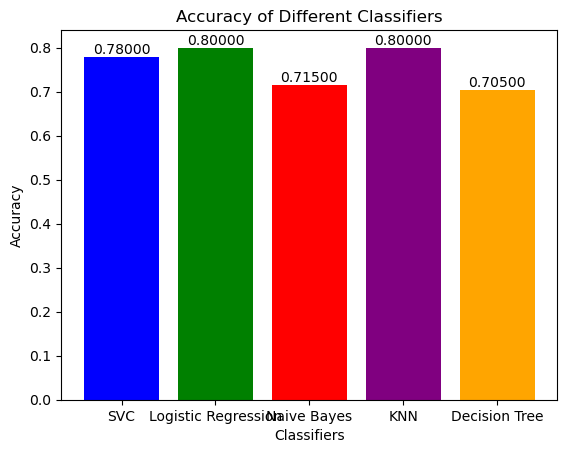

In [40]:
algorithms = ["SVC", "Logistic Regression", "Naive Bayes", "KNN", "Decision Tree"]
accuracy = [svc_accuracy, lr_accuracy, nb_accuracy, knn_accuracy, dt_accuracy]
colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.bar(algorithms, accuracy, color = colors)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Classifiers")
for i in range(len(algorithms)):
    plt.text(algorithms[i], accuracy[i], f'{accuracy[i]:.5f}', ha='center', va='bottom')
plt.savefig('log-standard-binning-ohe-ordinal.png')
plt.show()